# Загрузка библиотек

In [59]:
import os
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Подготовка данных

Объединим все отзывы (положительные и отрицательные) в единый файл. Один - для тренировочных данных, второй - для тестовых.

In [8]:
# пути к файлам с отзывами
TRAIN_POS = 'data\\train\\pos'
TRAIN_NEG = 'data\\train\\neg'
TEST_POS = 'data\\test\\pos'
TEST_NEG = 'data\\test\\neg'

In [9]:
# функция проходит по папке и сохраняет пути к файлам
def merge_reviews(path_pos, path_neg):
    ls = []
    
    for root, dirs, files in os.walk(path_pos):
        ls.extend([os.path.join(root,file) for file in files])    
    
    for root, dirs, files in os.walk(path_neg):
        ls.extend([os.path.join(root,file) for file in files])       
    
    return ls

In [10]:
# для обучения
ls_train = merge_reviews(TRAIN_POS, TRAIN_NEG)
# для теста
ls_test = merge_reviews(TEST_POS, TEST_NEG)

In [11]:
# для проверки (первые 12500 отзывов - положительные, вторые 12500 - отрицательные)

In [12]:
ls_train[:5]

['data\\train\\pos\\0_9.txt',
 'data\\train\\pos\\10000_8.txt',
 'data\\train\\pos\\10001_10.txt',
 'data\\train\\pos\\10002_7.txt',
 'data\\train\\pos\\10003_8.txt']

In [13]:
ls_train[-5:]

['data\\train\\neg\\9998_4.txt',
 'data\\train\\neg\\9999_3.txt',
 'data\\train\\neg\\999_3.txt',
 'data\\train\\neg\\99_1.txt',
 'data\\train\\neg\\9_1.txt']

In [14]:
len(ls_train)

25000

In [31]:
# сохраним в виде файла

# тренировочные данные
with open('data\\train_data.txt','w') as f:
    for file in ls_train: 
        s = open(file, errors="ignore").read()
        f.write(s)
        f.write('\n')
        
# тестовые данные 
with open('data\\test_data.txt','w') as f:
    for file in ls_test: 
        s = open(file, errors="ignore").read()
        f.write(s)
        f.write('\n')

In [32]:
# данные в виде списков

reviews_train = []
for line in open('data\\train_data.txt', 'r'):
    reviews_train.append(line.strip())
    
reviews_test = []
for line in open('data\\test_data.txt', 'r'):
    reviews_test.append(line.strip())

In [33]:
reviews_train[0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

In [34]:
reviews_test[0]

"I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge."

# Baseline model

## Подготовка данных

Сделаем простую предварительную подготовку данных: удалим знаки препинания и сделаем все буквы строчными.

In [35]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(reviews_train)
reviews_test_clean = preprocess_reviews(reviews_test)

In [36]:
# было
reviews_train[0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

In [37]:
# стало
reviews_train_clean[0]

'bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell highs satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled  at  high a classic line inspector im here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isnt'

## Векторизация

Полученные данные необходимо векторизовать. Самый простой способ - это CountVectorizer. В результате такой векторизации получим большую разреженную матрицу слов.

In [38]:
# создаем векторизатор
cv = CountVectorizer(binary=True)
# обучаем на трейн-данных
cv.fit(reviews_train_clean)
# векторизуем трейн и тест данные
X = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)

## Целевой признак

У нас есть две задачи:

1. Определение статуса комментария: положительный или отрицательный
2. Определени рейтинга (от 1 до 10)

### Статус комменатрия: положительный/отрицательный

Признак бинарный: 1 - положительный отзыв, 0 - отрицательный отзыв

In [39]:
# первые 12500 отзывов - положительные, вторые 12500 - отрицательные
# подходит как и для трейн и тест данных
target = [1 if i < 12500 else 0 for i in range(25000)]

# для проверки
print(target[:4])
print(target[12498:12502])
print(target[-4:])

[1, 1, 1, 1]
[1, 1, 0, 0]
[0, 0, 0, 0]


### Рейтинг (от 1 до 10)

Признак многоклассовый. Считаем рейтинги из названий файлов.

In [40]:
rating = []
for i in ls_train:
    rating.append(int(re.findall(r'_\d+', i)[0][1:]))

In [41]:
# для проверки

In [42]:
rating[:10]

[9, 8, 10, 7, 8, 8, 7, 7, 7, 7]

In [43]:
ls_train[:10]

['data\\train\\pos\\0_9.txt',
 'data\\train\\pos\\10000_8.txt',
 'data\\train\\pos\\10001_10.txt',
 'data\\train\\pos\\10002_7.txt',
 'data\\train\\pos\\10003_8.txt',
 'data\\train\\pos\\10004_8.txt',
 'data\\train\\pos\\10005_7.txt',
 'data\\train\\pos\\10006_7.txt',
 'data\\train\\pos\\10007_7.txt',
 'data\\train\\pos\\10008_7.txt']

In [44]:
rating_test = []
for i in ls_test:
    rating_test.append(int(re.findall(r'_\d+', i)[0][1:]))

In [45]:
rating_test[:10]

[10, 7, 9, 8, 8, 9, 8, 7, 10, 8]

In [46]:
ls_test[:10]

['data\\test\\pos\\0_10.txt',
 'data\\test\\pos\\10000_7.txt',
 'data\\test\\pos\\10001_9.txt',
 'data\\test\\pos\\10002_8.txt',
 'data\\test\\pos\\10003_8.txt',
 'data\\test\\pos\\10004_9.txt',
 'data\\test\\pos\\10005_8.txt',
 'data\\test\\pos\\10006_7.txt',
 'data\\test\\pos\\10007_10.txt',
 'data\\test\\pos\\10008_8.txt']

In [47]:
# сохраним в виде файла

# тренировочные данные
with open('data\\rating_train.txt','w') as f:
    f.write('\n'.join(str(i) for i in rating))
        
# тестовые данные 
with open('data\\rating_test.txt','w') as f:
    f.write('\n'.join(str(i) for i in rating_test))

Распределение оценок:

<AxesSubplot:ylabel='Count'>

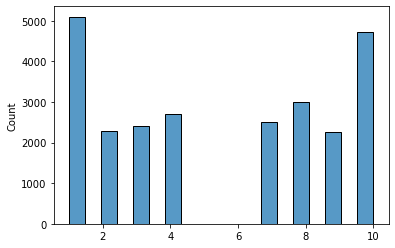

In [48]:
sns.histplot(rating)

<AxesSubplot:ylabel='Count'>

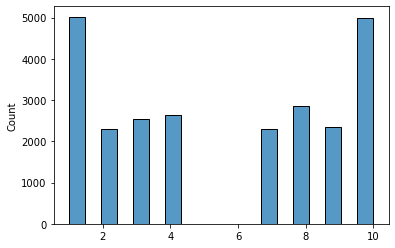

In [49]:
sns.histplot(rating_test)

# Обучение

### Cтатус комменатрия: положительный/отрицательный

Самая простая модель для обучения - Логистическая регресиия. Обучим как есть "из коробки", без подбора парметров.

In [50]:
# Разделение на трейн и валидацию
X_train, X_val, y_train, y_val = train_test_split(X, target, train_size = 0.8, random_state=10)

In [51]:
# модель
lr = LogisticRegression(solver = 'liblinear', random_state=10) # с 'lbfgs' выходит ошибка 'str' object has no attribute 'decode'
# обучение
lr.fit(X_train, y_train)
# точность на валидационных данных
accuracy_score(y_val, lr.predict(X_val))

0.8836

In [52]:
# обучим на всех данных
lr.fit(X, target)
# точность на тестовых данных
accuracy_score(target, lr.predict(X_test))

0.8692

### Рейтинг

In [53]:
# Разделение на трейн и валидацию
X_train, X_val, y_train, y_val = train_test_split(X, rating, train_size = 0.8, random_state=10)

In [54]:
# модель
lr1 = LogisticRegression(solver = 'liblinear', random_state=10) # с solver='lbfgs' выходит ошибка
# обучение
lr1.fit(X_train, y_train)
# точность на валидационных данных
accuracy_score(y_val, lr1.predict(X_val))

0.3804

In [55]:
# обучим на всех данных
lr1.fit(X, rating)
# точность на тестовых данных
accuracy_score(rating_test, lr1.predict(X_test))

0.36852

In [60]:
print(classification_report(rating_test, lr1.predict(X_test), \
    target_names = ['1', '2','3', '4', '7', '8', '9', '10']))

              precision    recall  f1-score   support

           1       0.55      0.65      0.60      5022
           2       0.19      0.16      0.17      2302
           3       0.22      0.18      0.20      2541
           4       0.27      0.25      0.26      2635
           7       0.24      0.22      0.23      2307
           8       0.23      0.22      0.22      2850
           9       0.20      0.15      0.17      2344
          10       0.50      0.59      0.54      4999

    accuracy                           0.37     25000
   macro avg       0.30      0.30      0.30     25000
weighted avg       0.34      0.37      0.35     25000



«recall» показывает меру полноты классификатора. Из отчета видно, что полнота миноритарных классов (2,3,4,7,8,9) гораздо меньше, то есть модель более склонна к классу большинства (1 и 10).

# Выводы

Базовая модель для определения статуса комментария (положительный/отрицательный) дает уже хорошие результаты при самой простой подготовке данных. 

Будем пытаться улучшить результаты при помощи более сложных способов предобработки, других алгоритмов. Также учтем дисбаланс классов во второй модели.